In [2]:
%cd ~/Dropbox/Stanford/CS_224N/Final_Project

/Users/elissali/Dropbox/Stanford/CS_224N/Final_Project


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import mixture
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

sns.set(color_codes=True)

In [4]:
data_df = pd.read_csv('./data_2.csv', sep=',')
means_df = pd.read_csv('./sentence_means_var.csv', sep=',')
annotated_df = pd.read_csv('./hand_annotated.csv', sep=',')
distrib_df = pd.read_csv('./datasets/seed_0/test_db.csv', sep=',')


def func(tgrep):
    if tgrep[-3:] == ':00':
        return tgrep[:-3]
    else: return tgrep
annotated_df['tgrep.id'] = annotated_df['tgrep.id'].apply(func)
means_df['tgrep.id'] = means_df['tgrep.id'].apply(func)

In [5]:
distrib_df[0:6]

,Item,Mean,Var,Alpha,Beta,Beta_Params,Mixed_Means,Mixed_Stds,Raw_Distrib,Discrete_Distrib,Sentence
0,164352:51,0.546667,0.119333,0.492825,0.362092,(0.4928251755022261 0.3620915386852378),[0.18258308 0.83801041],[0.10003483971618532 0.06267761041495623],[0.33 0.84 0.86 0.76 0.99 0.31 0.74 0.0...,[0.11111111 0. 0.22222222 0. 0...,i think in some cases it doesn't matter if it...
1,173504:75,0.666667,0.104422,0.304365,0.169157,(0.30436478242287335 0.1691570683290402),[0.88500025 0.23000163],[0.06889365897762463 0.0642977843208062],[0.21 1.0 0.86 0.69 0.9 0.13 0.91 0.95 ...,[0.11111111 0.11111111 0.11111111 0. 0...,and if you don't you'll perish. either by the ...
2,112347:54,0.566842,0.110874,0.531796,0.351648,(0.5317960082250381 0.35164841970003324),[0.7425799 0.07397243],[0.1274219484352285 0.024744727986892034],[0.53 0.73 0.09 0.89 0.88 0.64 0.75 0.1...,[0.26315789 0. 0.05263158 0.10526316 0...,"now, my kids didn't like it because they just ..."
3,113966:144,0.451111,0.082143,1.172429,0.863586,(1.1724290563691957 0.8635857726442795),[0.81302442 0.27770252],[0.05428152741979706 0.11368843168590435],[0.37 0.43 0.35 0.86 0.7 0.02 0.36 0.1 ...,[0.22222222 0. 0.33333333 0.11111111 0...,and finally our governor at the time which who...
4,155785:58,0.508889,0.066721,0.345911,0.222104,(0.34591075051904796 0.22210411312128392),[0.6833333 0.16 ],[0.06578971647599703 0.011568637396776152],[0.66 0.73 0.53 0.72 0.83 0.63 0.16 0.1...,[0.11111111 0.22222222 0. 0.11111111 0...,and we seem to be able to get along with the...
5,9072:53:00,0.404444,0.118825,0.251853,0.401979,(0.25185309059299565 0.4019789085496089),[0.86666778 0.17333675],[0.04842436546150406 0.0884830643388667],[0.18 0.02 0.34 0.77 0.03 0.32 0.92 0.1...,[0.22222222 0.22222222 0.22222222 0. 0...,"well, i was just going to say, it's a little ..."


In [6]:
a = data_df.groupby('tgrep.id')['response_val'].apply(list)
# a.keys()

# for i, tgrep in enumerate(a.keys()):
#     print(tgrep)

## Gaussian Mixture Preprocessing

First, below is the actual distribution of scores for a sentence:

In [7]:
x = distrib_df['Raw_Distrib'][0]
x

'[0.33  0.84  0.86  0.76  0.99  0.31  0.74  0.0  0.09]'

[0.33 0.84 0.86 0.76 0.99 0.31 0.74 0.   0.09]


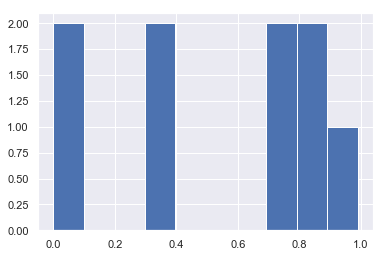

In [8]:
x = distrib_df['Raw_Distrib'][0]
x = x.strip(']')
x = x.strip('[')
x = x.split()
list_x = np.array(x, dtype=np.float32)
print(list_x)
plt.hist(list_x);

Need to reshape the list of scores so sklearn is willing to play with it (here's what it looks like):

In [9]:
list_x.reshape(-1, 1)

array([[0.33],
       [0.84],
       [0.86],
       [0.76],
       [0.99],
       [0.31],
       [0.74],
       [0.  ],
       [0.09]], dtype=float32)

Fit the sklearn Gaussian Mixture model over the actual distribution of scores, and plot what the resulting distribution looks like (using random sampling from the fitted model). This model assumes 2 components (i.e. 2 overlapping Gaussians).

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

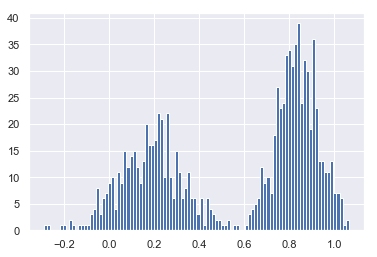

In [10]:
model = mixture.GaussianMixture(n_components=2)
fitted_model = model.fit(list_x.reshape(-1, 1))
plt.hist(fitted_model.sample(1000)[0], bins=100);   # nice semicolon = skip printing the giant array 

This isn't bad?!

Now, to get the mean and standard deviation for each component. The mean is straightforward:

In [11]:
means = fitted_model.means_.flatten()
means

array([0.83801041, 0.18258308])

Need some sorcery to get the standard deviation, but the internet says this works:
https://stackoverflow.com/questions/40874263/how-to-get-standard-deviation-from-each-components-in-sklearn-gmm-after-fit

In [12]:
cov = fitted_model.covariances_
stdevs = [ np.sqrt(  np.trace(cov[i])/2) for i in range(0,2) ]
stdevs

[0.06267761041495623, 0.10003483971618532]

As a sanity check: plot each of the component distribution PDFs (from the mean and standard deviation) to confirm that it roughly matches the component in the original Gaussian mixture.

loc is mean and scale is standard deviation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html

In [13]:
stats.norm.pdf(x=means[0], loc=means[0], scale=stdevs[0])

6.364988673949773

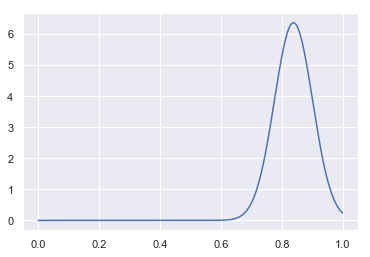

In [14]:
# Plot between -10 and 10 with .001 steps.
x_axis = np.arange(0, 1, 0.001)
# Mean = 0, SD = 2.
plt.plot(x_axis, stats.norm.pdf(x_axis,means[0],stdevs[0]))
plt.show()

# pytorch

Normal distributions in PyTorch: https://pytorch.org/docs/stable/generated/torch.normal.html

Mixture models: https://pytorch.org/docs/stable/distributions.html#mixturesamefamily

Example of mixed Gaussian: https://data-newbie.tistory.com/514

In [15]:
import torch
from torch import distributions as D
from torch.distributions.mixture_same_family import MixtureSameFamily

In [16]:
i = 0
mean_a = torch.Tensor([means[i]])
stdev_a = torch.Tensor([stdevs[i]])     # notice the extra brackets here
comp_a = D.Normal(mean_a[0], stdev_a[0])

In [17]:
i = 1
mean_b = torch.Tensor([means[i]])
stdev_b = torch.Tensor([stdevs[i]])     # notice the extra brackets here
comp_b = D.Normal(mean_b[0], stdev_b[0])

torch.Size([2])


/Users/elissali/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
/Users/elissali/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


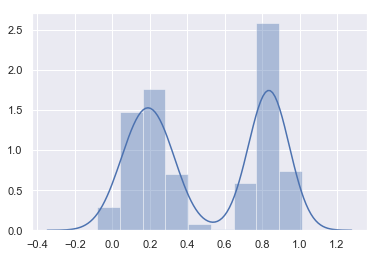

In [18]:
means = torch.cat((mean_a, mean_b))
print(means.shape)
stdevs = torch.cat((stdev_a, stdev_b))
comp = D.Normal(means, stdevs)
mix = D.Categorical(torch.ones(2,))

gmm = MixtureSameFamily(mix, comp)
sns.distplot(gmm.sample_n(1000).detach().numpy())

In [19]:
type(gmm)

torch.distributions.mixture_same_family.MixtureSameFamily

### Steps:

1. Use sklearn to fit gmm over scores for each sentence, and return (mean, standard deviation) for each component distribution `x 2` for each sentence in split_dataset.py
2. In models.py, read the component (mean, standard deviation) and fit it into a torch MixtureSameFamily distribution. 
3. In models.py, loss should be between two MixtureSameFamily distributions. 

# Scrapwork

In [20]:
def get_mixture(array):
    model = mixture.GaussianMixture(n_components=2)
    mixed_means = dict()
    mixed_stdevs = dict()
    for i, tgrep in enumerate(array.keys()):
        scores = np.array(array[tgrep], dtype=np.float32)
        fitted_model = model.fit(scores.reshape(-1, 1))
        mixed_means[tgrep] = fitted_model.means_.flatten()
        cov = fitted_model.covariances_
        mixed_stdevs[tgrep] = [ np.sqrt(  np.trace(cov[i])/2) for i in range(0,2) ]
    return mixed_means, mixed_stdevs 

In [21]:
data_df.head()

,tgrep.id,workerid,sentence_bnb,response_goodsentence,response_val,Trial,gender,age
0,362:41:00,365,"that's just a matter of defining priorities, i...",good bnb sentence,0.12,1,Female,31.0
1,362:41:00,366,"that's just a matter of defining priorities, i...",good bnb sentence,0.00,1,Male,32.0
2,362:41:00,367,"that's just a matter of defining priorities, i...",good bnb sentence,0.78,1,NaN,NaN
3,362:41:00,368,"that's just a matter of defining priorities, i...",bad bnb sentence,0.50,1,Male,36.0
4,362:41:00,369,"that's just a matter of defining priorities, i...",bad bnb sentence,0.90,1,Female,39.0


In [22]:
x = data_df.groupby('tgrep.id')['response_val'].apply(list).to_dict()   # {tgrep.id : [raw ratings]}

In [23]:
means, stds = get_mixture(x)

Some stuff on batches in distributions: https://bochang.me/blog/posts/pytorch-distributions/

In [24]:
ex_means = torch.rand([32,2])
ex_stds = torch.rand([32,2])

comp = D.Normal(ex_means, ex_stds)
comp.batch_shape

mix = D.Categorical(torch.ones(32,2,))       # I think this needs to be (32,2) instead of just (2,)

gmm = MixtureSameFamily(mix, comp)
# sns.distplot(gmm.sample_n(1000).detach().numpy())

In [25]:
gmm.sample()

tensor([ 0.8729,  0.6992,  0.7463,  0.8736,  1.4717,  0.1010,  0.8752, -0.4207,
         1.0379,  1.2924,  1.1207,  0.0579,  1.4370,  1.2095,  1.0967,  0.1769,
         0.2165, -0.7733,  0.7818, -0.5039,  0.0591,  1.0822,  1.2781,  0.3099,
         0.8279,  0.6739,  0.6451, -0.0851,  0.5384,  1.1823,  0.0756,  0.3436])

In [78]:
type(gmm)
type(comp)
comp
gmm

MixtureSameFamily(
  Categorical(probs: torch.Size([32, 2]), logits: torch.Size([32, 2])),
  Normal(loc: torch.Size([32, 2]), scale: torch.Size([32, 2])))

## Monte Carlo approximation of KL divergence? 

No analytic solution for KL divergence on mixed Gaussians; best you can do is a Monte Carlo approximation on the bounds: https://github.com/tensorflow/probability/issues/199

More on Monte Carlo here: https://www.tensorflow.org/probability/api_docs/python/tfp/monte_carlo/expectation

Example of Monte Carlo approximation of KL divergence between GMMs here: https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms?noredirect=1&lq=1

**TODO**: But can you even backprop through a Monte Carlo? Second paragraph of this thing says it's not possible to backprop through random samples: https://pytorch.org/docs/stable/distributions.html

### Monte Carlo attempt based on stackoverflow example: gmm_kl
 * in skl: score_samples = weighted log probs for each sample

In [71]:
def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample_n(n_samples)           # sample from first gmm a bunch of times: (n_samples,batch_size)
    log_p_X = gmm_p.log_prob(X)             # weighted log prob for samples in first gmm: (n_samples,batch_size)
    log_q_X = gmm_q.log_prob(X)             # weighted log prob for samples in second gmm: (n_samples,batch_size)
#     print(log_q_X)
#     print(log_q_X.mean())
    return log_p_X.mean() - log_q_X.mean()  # difference between average log probs for each gmm 

In [72]:
gmm_kl(gmm, gmm)

/Users/elissali/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


tensor(0.)

In [73]:
gmm_kl

<function __main__.gmm_kl(gmm_p, gmm_q, n_samples=100000)>

In [76]:
gmm.sample_n(10).size()

/Users/elissali/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


torch.Size([10, 32])

## towardsdatascience example: gnll

With random numbers, to check if it works:


In [ ]:
def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1)*components] for i in range(no_parameters)]

def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha, mu, sigma = slice_parameter_vectors(parameter_vector)  # Unpack parameter vectors
    
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    
    log_likelihood = gm.log_prob(tf.transpose(y))                 # Evaluate log-probability of y
    
    return -tf.reduce_mean(log_likelihood, axis=-1)

In [106]:
gm_gnll = MixtureSameFamily(mixture_distribution=D.Categorical(probs=torch.rand([32,2])), 
                            component_distribution=D.Normal(loc=torch.rand([32,2]), scale=torch.rand([32,2])))

In [101]:
log_likelihood = gm_gnll.log_prob(torch.Tensor([list_x.reshape(-1,1)]))

In [103]:
-torch.mean(log_likelihood, axis=-1)

tensor([[0.6629, 0.7918, 0.8128, 0.7414, 1.0218, 0.6689, 0.7371, 1.0396, 0.8053]])

### With actual example:

In [114]:
gm_2 = MixtureSameFamily(mixture_distribution=mix, 
                            component_distribution=comp)

log_likelihood = gm_gnll.log_prob(torch.Tensor(list_x.reshape(-1,1)))

print(log_likelihood.shape)

-torch.mean(log_likelihood, axis=-1)

torch.Size([9, 32])


tensor([0.5969, 0.9918, 1.0673, 0.6903, 1.5676, 0.5858, 0.6178, 1.1630, 0.9547])

In [110]:
-torch.mean(log_likelihood)

tensor(0.9150)

In [111]:
x = -torch.mean(log_likelihood, axis=-1)
x.mean()

tensor(0.9150)

# sense-check

for a batch of 32, D.Normal should create 32 normal distributions. And then when you call log_prob, you should get a tensor of (32,10) where 10 people scored the sentence.

**Question**: Is it actually storing 32 distributions? Or is it doing a weird multi-d normal?

**Question**: When you then apply log_prob, does it actually compute the log_prob for each? Does it choose the right normal distribution/the right mixture gaussian distribution to score the individual datapoints? Or is it weirdly assuming it's a big multidimensional gaussian?

**Test**: Create 2 fake parameters for 2 sets of normal distributions (2 means, 2 variances - and make them very different). Like (0.1, 0.3) and (0.7, 0.9). And then you can construct a D.Normal where you just give it 2 means and 2 variances, and then create the mixture family as we do in the code... and then score datapoints and make sure that when you score a tensor of size ([2,10]), that you get the same results as when you score both rows of that tensor individually...

### Example:

#### Is D.Normal storing multiple distributions?

Suppose we have 3 examples (like 3 training examples), each of which has 2 component distributions. So `test_means` has shape (3,2) -- one mean for each of the two components, and then two components for each of the three training examples. We store this in a D.Normal, which has a batch shape of (3,2). 

In [184]:
test_means = torch.rand([3,2])           # (number of examples, number of components per example)
test_stds = torch.rand([3,2])

test_normal = D.Normal(test_means, test_stds)
test_normal.batch_shape

torch.Size([3, 2])

Then we sample 10000 times from the D.Normal (which we named `test_normal`). So now we have a tensor with the following shape:

`[num_samples per example, num_examples, num_components per example]`, i.e. (10000, 3, 2).

In [185]:
samples = test_normal.sample((10000,))
samples.shape

torch.Size([10000, 3, 2])

Now we check whether `test_normal` is actually storing the distributions we want it to. We know what the means are for each distribution and each component (stored in `test_means`), so we can compare the means from `test_means` with the calculated means from our sample and confirm that they line up. 

Which they do! The below cell checks this for each of the two components for the first training example. So it's taking the first pair of means from `test_means`, and then comparing them to the sample means (sampled from the previous cell).

torch.Size([10000])
component means:  tensor([0.0425, 0.1915])
sample means:  tensor(0.0395) ,  tensor(0.1913)


/Users/elissali/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


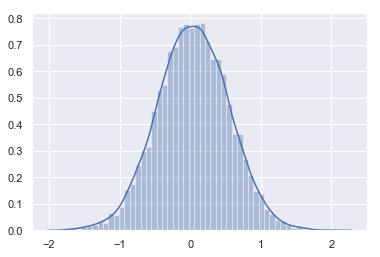

In [186]:
comp1 = samples[:,0,0]
comp2 = samples[:,0,1]
print(comp1.shape)
print("component means: ", test_means[0])
print("sample means: ", comp1.mean(), ", ", comp2.mean())
sns.distplot(comp1);

#### Does log_prob actually compute the log probabilities for each gaussian mix, in a batch?

Okay, so we now know that D.Normal is storing multiple distributions like we wanted (in `test_normal`). Now, if we feed `test_normal` into MixtureSameFamily and then take the log_prob of a list of samples (`list_x`), does it take the log_prob correctly?

In [187]:
test_normal        # batch_size=3, num_components=2

Normal(loc: torch.Size([3, 2]), scale: torch.Size([3, 2]))

In [188]:
test_mix = D.Categorical(torch.ones([3,2]))

In [189]:
test_gm = MixtureSameFamily(mixture_distribution = test_mix, component_distribution = test_normal)

This is the actual y (i.e. the array of 9 scores that the 9 humans gave for a particular sentence). In general, we want to see how likely it is that this actual y (`test_array`) comes from the mixed Gaussian `test_gm` by getting its log likelihood. 

The resulting output is (9 x 3): for each of the 3 examples (i.e. 3 mixed Gaussians), the log likelihood of the 9 scores:

In [190]:
test_array = torch.Tensor(list_x.reshape(-1,1))

In [191]:
test_gm.log_prob(test_array)

tensor([[-0.3707, -1.1107, -0.1537],
        [-1.2282, -1.1443, -1.2274],
        [-1.2799, -1.1510, -1.2277],
        [-1.0350, -1.1159, -1.2350],
        [-1.6479, -1.2192, -1.2504],
        [-0.3554, -1.2529, -0.7024],
        [-0.9900, -1.0917, -1.2391],
        [-0.3021, -1.8220, -1.9960],
        [-0.2820, -1.6604, -1.8408]])

Let's check the first example (i.e. a MixtureSameFamily for just the first example). It would be this:

In [194]:
single_mix = D.Categorical(torch.ones([2]))
single_normal = D.Normal(test_means[0], test_stds[0])
single_gm = MixtureSameFamily(mixture_distribution = single_mix, component_distribution = single_normal)

The below should be identical to the first column of the (9 x 3) output -- which it is! Hooray!

In [196]:
single_gm.log_prob(test_array)

tensor([[-0.3707],
        [-1.2282],
        [-1.2799],
        [-1.0350],
        [-1.6479],
        [-0.3554],
        [-0.9900],
        [-0.3021],
        [-0.2820]])